**Глинский Максим, М-26**

**Метрика IoU и алгоритм NMS**

In [1]:
import numpy as np
from typing import List, Tuple

def iou(box1: np.ndarray, box2: np.ndarray) -> float:
    # Определение координат пересечения
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Площадь пересечения (если нет пересечения = 0)
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    # Площади каждого бокса
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Площадь объединения
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0

def nms(boxes: List[np.ndarray], scores: List[float], iou_threshold: float = 0.5) -> List[int]:
    # Алгоритм Non-Maximum Suppression
    sorted_indices = np.argsort(scores)[::-1]
    keep = []

    while len(sorted_indices) > 0:
        # Выбираем бокс с максимальным score
        current_idx = sorted_indices[0]
        keep.append(current_idx)

        # Вычисляем IoU выбранного бокса с остальными
        current_box = boxes[current_idx]
        remaining_indices = sorted_indices[1:]

        # Фильтрация боксов с высоким перекрытием
        filtered_indices = []
        for idx in remaining_indices:
            if iou(current_box, boxes[idx]) <= iou_threshold:
                filtered_indices.append(idx)

        sorted_indices = filtered_indices

    return keep

# Пример bounding boxes [x1, y1, x2, y2]
boxes = [
  np.array([10, 10, 50, 50]),    # box 0
  np.array([15, 15, 55, 55]),    # box 1 (сильно пересекается с box 0)
  np.array([100, 100, 150, 150]), # box 2 (далеко от остальных)
  np.array([20, 20, 60, 60]),    # box 3 (пересекается с box 0 и 1)
]

scores = [0.9, 0.8, 0.95, 0.7]

print("Исходные данные:")
for i, (box, score) in enumerate(zip(boxes, scores)):
  print(f"Box {i}: {box}, Score: {score:.2f}")

# Применяем NMS с порогом 0.5
kept_indices = nms(boxes, scores, iou_threshold=0.5)

print("\nРезультат NMS (порог IoU = 0.5):")
print(f"Оставшиеся боксы: {kept_indices}")

for idx in kept_indices:
  print(f"Box {idx}: {boxes[idx]}, Score: {scores[idx]:.2f}")

# Демонстрация вычисления IoU
print("\nПример вычисления IoU:")
print(f"IoU(box0, box1) = {iou(boxes[0], boxes[1]):.3f}")
print(f"IoU(box0, box2) = {iou(boxes[0], boxes[2]):.3f}")

Исходные данные:
Box 0: [10 10 50 50], Score: 0.90
Box 1: [15 15 55 55], Score: 0.80
Box 2: [100 100 150 150], Score: 0.95
Box 3: [20 20 60 60], Score: 0.70

Результат NMS (порог IoU = 0.5):
Оставшиеся боксы: [np.int64(2), np.int64(0), np.int64(3)]
Box 2: [100 100 150 150], Score: 0.95
Box 0: [10 10 50 50], Score: 0.90
Box 3: [20 20 60 60], Score: 0.70

Пример вычисления IoU:
IoU(box0, box1) = 0.620
IoU(box0, box2) = 0.000


 **Обнаружение объектов с помощью предобученной модели**


Обработка изображения: http://images.cocodataset.org/val2017/000000179765.jpg


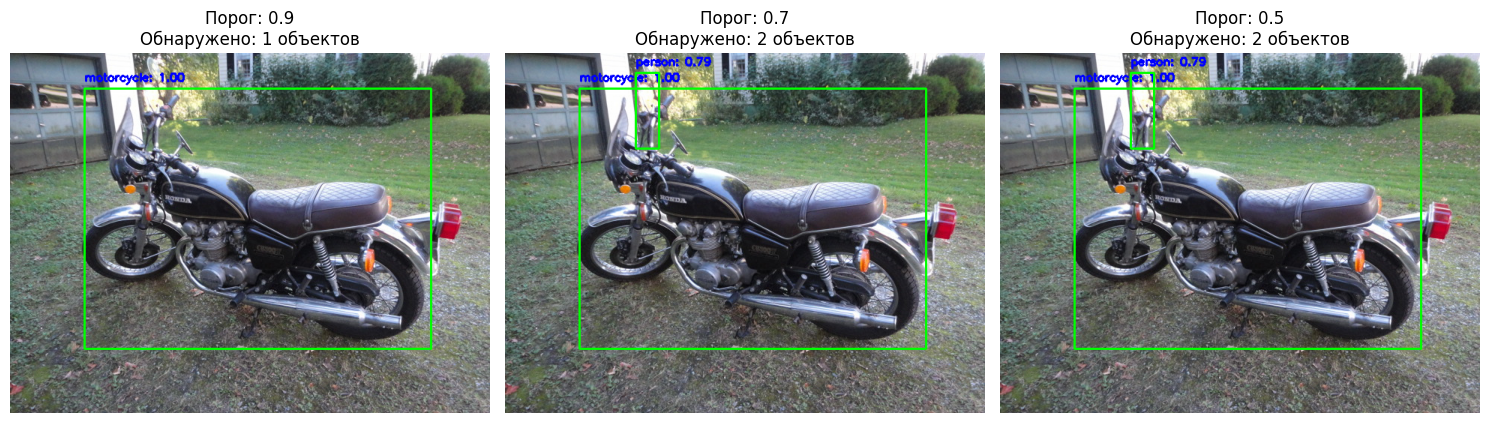

Статистика обнаружения для изображения:
  Порог 0.9: 1 объектов, 1 классов
  Порог 0.7: 2 объектов, 2 классов
  Порог 0.5: 2 объектов, 2 классов

Обработка изображения: http://images.cocodataset.org/val2017/000000046378.jpg


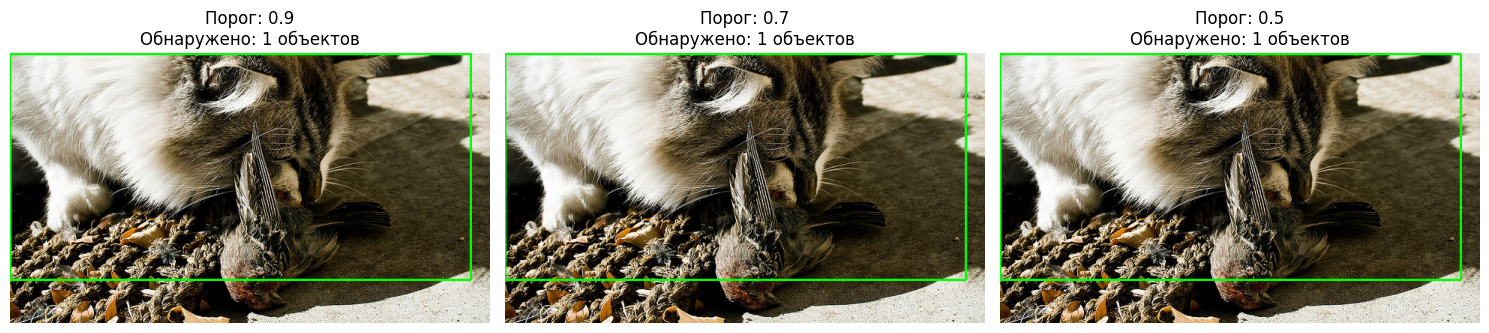

Статистика обнаружения для изображения:
  Порог 0.9: 1 объектов, 1 классов
  Порог 0.7: 1 объектов, 1 классов
  Порог 0.5: 1 объектов, 1 классов

Обработка изображения: http://images.cocodataset.org/val2017/000000482917.jpg


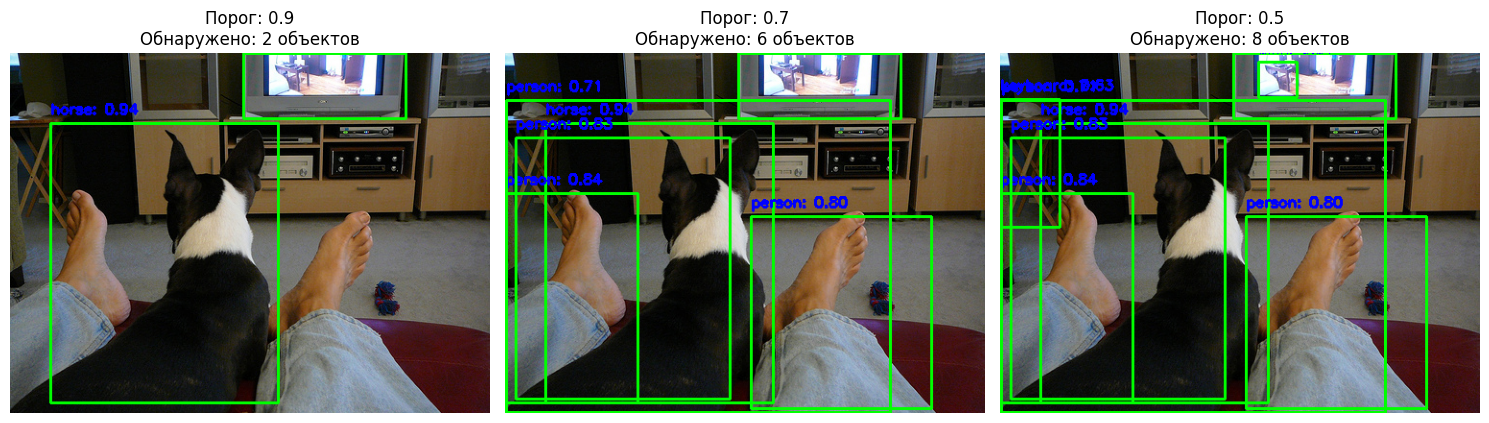

Статистика обнаружения для изображения:
  Порог 0.9: 2 объектов, 2 классов
  Порог 0.7: 6 объектов, 3 классов
  Порог 0.5: 8 объектов, 4 классов

Обработка изображения: http://images.cocodataset.org/val2017/000000012667.jpg


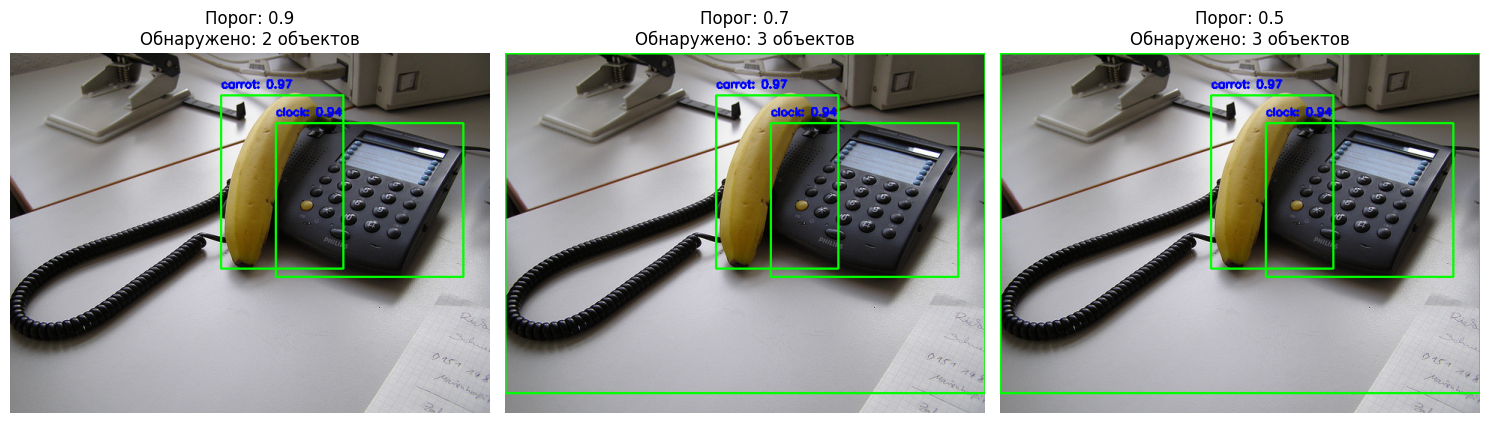

Статистика обнаружения для изображения:
  Порог 0.9: 2 объектов, 2 классов
  Порог 0.7: 3 объектов, 3 классов
  Порог 0.5: 3 объектов, 3 классов


In [6]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# COCO классы
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

def visualize_detections(image, boxes, labels, scores, threshold=0.5):
    img = np.array(image)

    for box, label, score in zip(boxes, labels, scores):
        if score < threshold:
            continue

        # Координаты bounding box
        x1, y1, x2, y2 = map(int, box)

        # Рисуем прямоугольник
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Подпись с классом и уверенностью
        text = f"{COCO_CLASSES[label]}: {score:.2f}"
        cv2.putText(img, text, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return img

def detect_objects(model, image, confidence_threshold=0.5):
    # Преобразование изображения
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])

    img_tensor = transform(image).unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        predictions = model(img_tensor)

    # Извлечение результатов
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Фильтрация по порогу уверенности
    mask = scores >= confidence_threshold
    return boxes[mask], labels[mask], scores[mask]

# Загрузка модели
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
)
model.eval()

# Тестовые изображения из COCO
coco_image_urls = [
    "http://images.cocodataset.org/val2017/000000179765.jpg",
    "http://images.cocodataset.org/val2017/000000046378.jpg",
    "http://images.cocodataset.org/val2017/000000482917.jpg",
    "http://images.cocodataset.org/val2017/000000012667.jpg",
]

# Эксперимент с разными порогами уверенности
for url in coco_image_urls:  # Протестируем на первых двух изображениях
    print(f"\nОбработка изображения: {url}")
    image = load_image_from_url(url)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, threshold in enumerate([0.9, 0.7, 0.5]):
        boxes, labels, scores = detect_objects(model, image, threshold)
        result_img = visualize_detections(image, boxes, labels, scores, threshold)

        axes[i].imshow(result_img)
        axes[i].set_title(f'Порог: {threshold}\nОбнаружено: {len(boxes)} объектов')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Статистика для каждого порога
    print(f"Статистика обнаружения для изображения:")
    for threshold in [0.9, 0.7, 0.5]:
        boxes, labels, scores = detect_objects(model, image, threshold)
        unique_classes = set([COCO_CLASSES[l] for l in labels])
        print(f"  Порог {threshold}: {len(boxes)} объектов, {len(unique_classes)} классов")

Высокий порог (0.9):
- Обнаруживаются только самые уверенные объекты
- Меньше ложных срабатываний
- Пропускаются небольшие, частично закрытые или нестандартные объекты

Средний порог (0.7):
- Обнаруживает большинство значимых объектов
- Некоторые ложные срабатывания на сложных участках
- Лучший компромисс для большинства приложений

Низкий порог (0.5):
- Обнаруживает еще больше объектов
- Появляются ложные срабатывания
- Детектирует маленькие и менее уверенные объекты

Как итог: выбор порога confidence - критически важный гиперпараметр

**Семантическая vs. поэкземплярная сегментация**

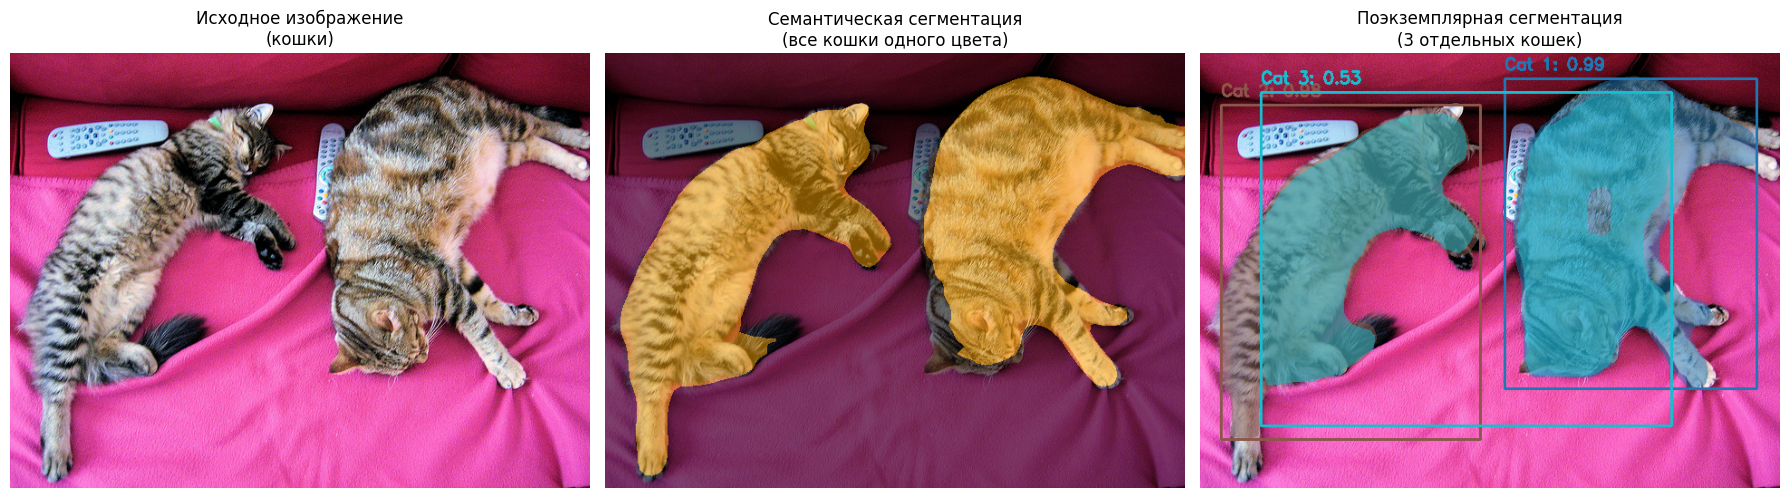


Семантическая сегментация:
- Пикселей класса 'cat': 104110
- Всего классов на изображении: 2

Поэкземплярная сегментация:
- Обнаружено кошек: 3
  Кошка 1: уверенность 0.990
  Кошка 2: уверенность 0.981
  Кошка 3: уверенность 0.529


In [10]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import cv2

# COCO классы
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def load_image_from_url(url):
    """Загрузка изображения по URL"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

# Загрузка изображения с несколькими объектами одного класса (кошки)
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = load_image_from_url(url)

# Преобразование изображения для моделей
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

img_tensor = transform(image).unsqueeze(0)

# 1. Модель для семантической сегментации (DeepLabV3)
semantic_model = torchvision.models.segmentation.deeplabv3_resnet50(
    weights=torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
)
semantic_model.eval()

# 2. Модель для поэкземплярной сегментации (Mask R-CNN)
instance_model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.COCO_V1
)
instance_model.eval()

# Применение моделей
with torch.no_grad():
    # Семантическая сегментация
    semantic_output = semantic_model(img_tensor)
    semantic_mask = semantic_output['out'].squeeze(0).argmax(0).cpu().numpy()

    # Поэкземплярная сегментация
    instance_output = instance_model(img_tensor)
    instance_masks = instance_output[0]['masks'].cpu().numpy()
    instance_labels = instance_output[0]['labels'].cpu().numpy()
    instance_scores = instance_output[0]['scores'].cpu().numpy()
    instance_boxes = instance_output[0]['boxes'].cpu().numpy()

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Исходное изображение
axes[0].imshow(image)
axes[0].set_title('Исходное изображение\n(кошки)')
axes[0].axis('off')

# 2. Семантическая сегментация
# VOC-классы для DeepLabV3: 0-background, 1-aeroplane, 2-bicycle, ..., 8-cat, ...
# Класс "cat" имеет индекс 8 в Pascal VOC (который используется в DeepLabV3)
img_array = np.array(image)
semantic_colored = np.zeros_like(img_array)

# Окрашиваем маску (класс "cat" = 8 в VOC-классах)
cat_mask = semantic_mask == 8  # Класс "cat" в VOC (Pascal VOC classes)
semantic_colored[cat_mask] = [255, 165, 0]  # Оранжевый цвет для кошек

# Смешиваем с исходным изображением
alpha = 0.5
blended = (img_array * (1 - alpha) + semantic_colored * alpha).astype(np.uint8)

axes[1].imshow(blended)
axes[1].set_title('Семантическая сегментация\n(все кошки одного цвета)')
axes[1].axis('off')

# 3. Поэкземплярная сегментация
instance_result = img_array.copy()

# Фильтрация по порогу уверенности и классу "cat" (класс 17 в COCO)
cat_indices = np.where((instance_labels == 17) & (instance_scores > 0.5))[0]

# Разные цвета для разных экземпляров
if len(cat_indices) > 0:
    colors = plt.cm.get_cmap('tab10', len(cat_indices))

    for i, idx in enumerate(cat_indices):
        color = np.array(colors(i))[:3] * 255  # RGB компоненты

        # Применяем маску
        mask = instance_masks[idx, 0] > 0.5

        # Окрашиваем маску
        for c in range(3):
            instance_result[:, :, c] = np.where(
                mask,
                instance_result[:, :, c] * 0.5 + color[c] * 0.5,
                instance_result[:, :, c]
            )

        # Рисуем bounding box
        box = instance_boxes[idx].astype(int)
        cv2.rectangle(instance_result, (box[0], box[1]), (box[2], box[3]), color.tolist(), 2)

        # Подпись с номером экземпляра и уверенностью
        cv2.putText(instance_result, f'Cat {i+1}: {instance_scores[idx]:.2f}',
                    (box[0], box[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color.tolist(), 2)
else:
    print("Не обнаружено кошек с уверенностью выше 0.5")

axes[2].imshow(instance_result)
axes[2].set_title(f'Поэкземплярная сегментация\n({len(cat_indices)} отдельных кошек)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Статистика
print(f"\nСемантическая сегментация:")
print(f"- Пикселей класса 'cat': {np.sum(cat_mask)}")
print(f"- Всего классов на изображении: {len(np.unique(semantic_mask))}")

print(f"\nПоэкземплярная сегментация:")
print(f"- Обнаружено кошек: {len(cat_indices)}")
if len(cat_indices) > 0:
    for i, idx in enumerate(cat_indices):
        print(f"  Кошка {i+1}: уверенность {instance_scores[idx]:.3f}")

В семантической сегментации:
- Все пиксели, принадлежащие одному классу, получают одинаковую метку
- Невозможно определить количество экземпляров

В поэкземплярной сегментации
- Каждый объект имеет свою уникальную маску
- Можно точно подсчитать количество объектов

Почему для instance-сегментации требуется сочетание детектирования и сегментации:
Детектирование необходимо для:

- Нахождения отдельных объектов (bounding boxes)

- Разделения перекрывающихся экземпляров

- Определения того, какие пиксели к какому объекту относятся

Сегментация необходима для:

- Точного определения границ объектов

- Создания пиксельных масок для каждого экземпляра

Выводы:

Семантическая сегментация эффективна для задач, где важно знать "что где находится", но не важно "сколько отдельных объектов"

Поэкземплярная сегментация решает более сложную задачу, комбинируя детектирование и сегментацию. Позволяет работать с каждым объектом индивидуально. Но требует больше вычислительных ресурсов.